In [24]:
import json
import piexif
from PIL import Image
import os
import pickle
from shutil import copyfile, unpack_archive, move
import pandas as pd
from scrapper import scrapper

In [25]:
with open("meta.json", encoding="UTF-8") as fl:
    meta=json.load(fl)
meta

{'github': {'commit': '659e7e0df1ac7d7e876d07c33341f2e625cba3d4',
  'repo': 'borutb-fri/FMLD'},
 'annotations': {'id': 'FMLD_annotations.zip', 'src': 'github'},
 'train': [{'img': {'id': '15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M',
    'out': 'wide-train.zip',
    'src': 'drive'}},
  {'img': {'id': '17bRIiaGyrKLEDQOV2RlqbPQ9TyCZxq9k',
    'out': 'mafa-train.zip',
    'src': 'drive'}}],
 'test': [{'img': {'id': '1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q',
    'out': 'wide-test.zip',
    'src': 'drive'}},
  {'img': {'id': '1jJHdmmscqxvNQ2dxKUrLaHqW3w1Yo_9S',
    'out': 'mafa-test.zip',
    'src': 'drive'}}]}

In [5]:
github_info = meta["github"]

In [6]:
scrapper(meta["annotations"], github_info)

In [ ]:
[scrapper(el['img'], github_info) for el in meta["train"]]
[scrapper(el['img'], github_info) for el in meta["test"]] 

In [9]:
unpack_archive("FMLD_annotations.zip", ".")
unpack_archive("wide-test.zip", ".")
unpack_archive("wide-train.zip", ".")
unpack_archive("mafa-test.zip", ".")
move("images", "test-images")
unpack_archive("mafa-train.zip", ".")
move("images", "train-images")

'train-images'

In [26]:
import cv2
import xml.etree.ElementTree as ET

class Annotation:
    THRESHOLD = 50
    
    def __init__(self, root):
        if not os.path.isdir(root):
            raise Exception("FUCK")
        self.iter = (f"{subs}/{fl}" for subs, dirs, fls in os.walk(root) for fl in fls)
    
    def save_faces(self):
        to_int = lambda val: int(float(val))
        get_object = lambda obj, w, h, d: {
                "name": obj.find("name").text,
                "gender": obj.find("gender").text,
                "ethnisity": obj.find("ethnicity").text,
                "pose": obj.find("pose").text,
                "truncated": obj.find("truncated").text,
                "difficult": obj.find("difficult").text,
                "x0": max(0, to_int(obj.find("bndbox").find("xmin").text)),
                "y0": max(0, to_int(obj.find("bndbox").find("ymin").text)),
                "x1": min(w, to_int(obj.find("bndbox").find("xmax").text)),
                "y1": min(h, to_int(obj.find("bndbox").find("ymax").text)),
        }
        
        for fl in self.iter:
            try:
                name, _ = fl.split(".xml")
                *_, name = name.split(os.sep)
            except:
                print(name)
                continue
            
            root = ET.parse(fl)
            path = root.find("path").text
            folder = root.find("folder").text
            if not os.path.isdir(folder):
                os.mkdir(folder)
            source = root.find("source").find("database").text
            size = root.find("size")
            dim = {
                "w": to_int(size.find("width").text), 
                "h": to_int(size.find("height").text), 
                "d": to_int(size.find("depth").text)
            }
            segmented = root.find("segmented").text
            faces = self.__get_faces(map(lambda obj: get_object(obj, **dim), root.findall("object")), path)
            for ind, (face, exif) in enumerate(faces):
                face_path = f"{folder}{os.sep}{name}_{ind}.jpg"
                face.save(face_path, exif=exif)
    
    def read_faces(self):
        for fl in self.iter:   
            meta = self.face_meta(fl)
            meta["src"] = fl
            yield meta
            
    
    @staticmethod
    def __face_exif(path, obj_dict): 
        return piexif.dump({"Exif": {piexif.ExifIFD.MakerNote: pickle.dumps({
            "path": path,
            **obj_dict
        })}})
    
    @staticmethod
    def face_meta(path):
        exif_dict = piexif.load(path)
        return pickle.loads(exif_dict["Exif"][piexif.ExifIFD.MakerNote])
    
    @staticmethod
    def __get_faces(objs, fl):
        img = cv2.imread(fl)
        if img is None:
            raise Exception(f"No image: {fl}")
        for obj in objs:
            y0,y1,x0,x1 = obj["y0"],obj["y1"],obj["x0"],obj["x1"]
            
            if min((y1 - y0), (x1 - x0)) < Annotation.THRESHOLD:
                continue
            face = img[y0:y1, x0:x1, :]
            yield (Image.fromarray(face), Annotation.__face_exif(fl, obj))

In [11]:
A = Annotation("FMLD_annotations")
A.save_faces()

libpng warning: sBIT: invalid
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [27]:
test = Annotation("test")
train = Annotation("train")
test_df = pd.DataFrame(test.read_faces());
train_df = pd.DataFrame(train.read_faces());

In [28]:
test_df = test_df[test_df["gender"] != "unspecified"]

<AxesSubplot:>

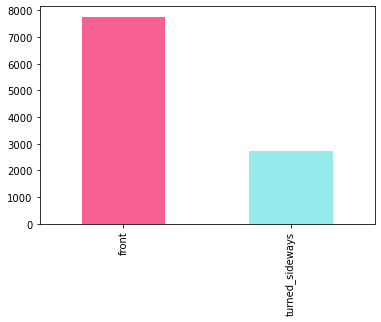

In [7]:
test_df["pose"].value_counts().plot.bar(color = ['#F66095', '#95ebec'])

<AxesSubplot:>

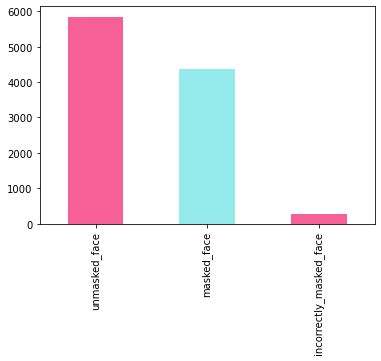

In [10]:
test_df["name"].value_counts().plot.bar(color = ['#F66095', '#95ebec'])

<AxesSubplot:>

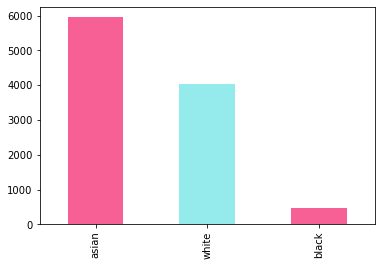

In [9]:
test_df["ethnisity"].value_counts().plot.bar(color = ['#F66095', '#95ebec'])

<AxesSubplot:>

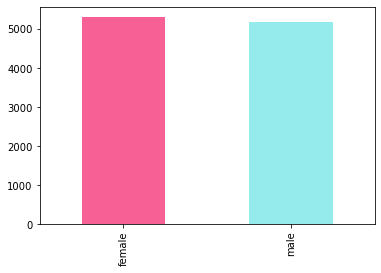

In [10]:
test_df["gender"].value_counts().plot.bar(color = ['#F66095', '#95ebec'])

In [11]:
print(f"Test data-set size: {len(test_df)}")

Test data-set size: 10481


<AxesSubplot:>

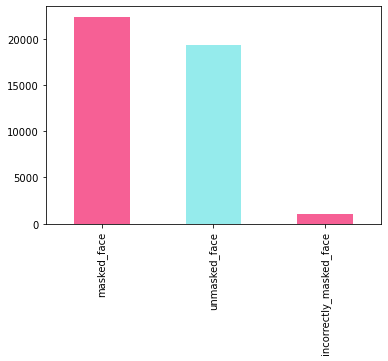

In [12]:
train_df["name"].value_counts().plot.bar(color = ['#F66095', '#95ebec'])

In [13]:
print(f"Train data-set size: {len(train_df)}")

Train data-set size: 42761


In [29]:
train_df.head()

,path,name,gender,ethnisity,pose,truncated,difficult,x0,y0,x1,y1,src
0,WIDER_train/images/0--Parade/0_Parade_Parade_0...,unmasked_face,unspecified,unspecified,unspecified,0,0,457,189,510,251,train/0_Parade_Parade_0_1019_0.jpg
1,WIDER_train/images/0--Parade/0_Parade_Parade_0...,unmasked_face,unspecified,unspecified,unspecified,0,0,413,200,465,257,train/0_Parade_Parade_0_1019_1.jpg
2,WIDER_train/images/0--Parade/0_Parade_Parade_0...,unmasked_face,unspecified,unspecified,unspecified,0,0,704,110,793,218,train/0_Parade_Parade_0_1019_2.jpg
3,WIDER_train/images/0--Parade/0_Parade_Parade_0...,unmasked_face,unspecified,unspecified,unspecified,0,0,523,164,588,245,train/0_Parade_Parade_0_1019_3.jpg
4,WIDER_train/images/0--Parade/0_Parade_Parade_0...,unmasked_face,unspecified,unspecified,unspecified,0,0,849,189,901,256,train/0_Parade_Parade_0_1019_4.jpg


In [59]:
def form_ds(df: pd.DataFrame, dsroot: str, ubound:int=None):
    create_dir = lambda dir_: (os.mkdir(dir_) if not os.path.isdir(dir_) else None) or dir_
    type_, *_ = df.iloc[0]["src"].split(os.sep)
    create_dir(dsroot)
    type_folder = create_dir(f"{dsroot}{os.sep}{type_}")
    
    tags = df.groupby("name")
    tags_num = len(tags)
    
    for name, tag in tags:
        class_name = "correct" if name == "masked_face" else "incorrect"
        class_path = create_dir(f"{type_folder}{os.sep}{class_name}")
        save_file = lambda x: copyfile(x['src'], f"{class_path}{os.sep}{x['src'].split(os.sep)[-1]}")
        
        size = len(tag)
        allowed = int(size if ubound is None else min(size, ubound/tags_num))
        print(f"{name}: {allowed} faces")
        tag.sample(allowed).apply(save_file, axis=1)
        
        
    return
    type_, *_ = df.iloc[0]["src"].split(os.sep)
    classes = { 
        "correct": {
            "check": lambda x: x == "masked_face",
            "total": None
        },
        "incorrect": {
            "check": lambda x: x != "masked_face",
            "total": None
        }
    }
    
    num_cls = len(classes)
    if ubound is not None:
        for cls in classes:
            classes[cls]["total"] = ubound//num_cls
    
    
    
    if not os.path.isdir(dsroot):
        os.mkdir(dsroot)
        
    type_folder = f"{dsroot}{os.sep}{type_}"

    if not os.path.isdir(type_folder):
        os.mkdir(type_folder)
    
    def dist(row):
        tag = row["name"]
        tag_folder = None
        for cls in classes:
            n = classes[cls]["total"]
            if n is not None and n <= 0:
                continue
            if classes[cls]["check"](tag):
                tag_folder = cls
                if n is not None:
                    classes[cls]["total"]-=1
                break
                
        if tag_folder is None:
            return
        fl_path = row["src"]
        tag_path = f"{type_folder}{os.sep}{tag_folder}"
        *_, fl_name = fl_path.split(os.sep)
        if not os.path.isdir(tag_path):
            os.mkdir(tag_path)
        copyfile(fl_path, f"{tag_path}{os.sep}{fl_name}")

    df.apply(dist, axis=1)

In [65]:
form_ds(train_df, "_Balance", 3000)
form_ds(test_df, "_Balance", 750)

incorrectly_masked_face: 1000 faces
masked_face: 1000 faces
unmasked_face: 1000 faces
incorrectly_masked_face: 250 faces
masked_face: 250 faces
unmasked_face: 250 faces
